<h1 style="text-align: center;"> Badanie efektywności algorytmu unikania kolizji w przestrzeni powietrznej</h1>
<h4 style="text-align: center;"> Data wykonania: 01.05.2024 </h3>
<h4 style="text-align: center;"> Autor: Mikołaj Wegner </h3>

<h3>0. Platforma badawcza </h3>

Sprzęt:
Dell XPS 13 9310
- Procesor: Intel Core i7-1185G7 @ 3.00GHz
- Pamięć RAM: 16 GB
- OS: Windows 11 Home

Oprogramowanie:
- Python 3.9.7
- Jupyter Notebook 6.4.3
- CPLEX Studio 22.1.1

<h3>1. Cel badania </h3>

Celem eksperymentu jest zbadanie efektywności algorytmu ILOG CPLEX rozwiązującego optumalizacyjny problem dekonfliktacji przy zmieniających się rozmiarach i parametrach instancji (sformułowany jako MIP - Mixed Integer Programming Problem). W badaniu zostaną porównane czasy rozwiązania problemu dla różnych instancji oraz zbadane wpływ parametrów instancji na czas rozwiązania problemu.

<h3>2. Słownik pojęć </h3>

Rozmiar problemu - ustalone wartości podstawowych parametrów problemu:
- n - liczba statków powietrznych
- m - liczba manewrów dla każdego statku powietrznego (taka sama dla wszystkich statków powietrznych)

Parametry problemu = wartości mające wpływ na prawdopodobieństwo wystąpienia konfliktu między statkami powietrznymi:
- p - prawdopodobieństwo wystąpienia konfliktu między dwoma statkami powietrznymi poruszającymi się po pierwotnie ustalonych trasach (dla $m = 1, p \in (0, 1]$)
- w - miara "zachowania konfliktu" przy rosnącej liczbe możliwych do wykonania manewrów (im większa wartość, tym mniejszy efekt przynosi zwiększanie liczby manewrów; inaczej - im większa wartość, tym mniejsza szansa by dodawany kolejny manewr pozwolił uniknąć konfliktu, w > 0
- p<sub>m</sub> - prawdopodobieństwo wystąpienia konfliktu między dwoma statkami powietrznymi dla przyjętej liczby m możliwych manewrów wyrażone jest wzorem:
$$
\boldsymbol{p_m = p \cdot 2^{\frac{(1 - m)}{w}}}
$$



<h3>3. Użyte biblioteki</h3>

In [1]:
import docplex.mp.model as cplex
import pandas as pd
import numpy as np
import re
import os
import glob
import matplotlib.pyplot as plt

<h3>4. Generowanie instancji problemu</h3>

Funkcja <b>generate_instance</b> generuje macierz prawdopodobieństw konfliktów dla instancji problemu o zadanych parametrach.
Funkcja <b>save_instances</b> zapisuje instancje problemu do plików tekstowych w odpowiednich katalogach.
Funkcja <b>generate_all_instances</b> generuje <b>n (domyślnie 10)</b> instancji problemu dla wszystkich kombinacji parametrów i zapisuje je do plików tekstowych.

<h5> Badane wartości parametrów: </h5>

$$
n \in \{10, 20, 30, 40\} \\
m \in \{3, 5, 7, 9\} \\
p \in \{0.6, 0.8, 1\} \\
w \in \{1, 5, 10\}
$$


In [2]:
def generate_instance(n, m, p, w):
    size = n * m
    p_m = p * 2**((1 - m) / w)
    # print(p_m)
    matrix = np.random.choice([0, 1], size=(size, size), p=[1 - p_m, p_m])
    np.fill_diagonal(matrix, 1)
    return matrix

In [3]:
def save_instances(matrix, n, m, p, w, i):
    dir = f'./data/n={n}_m={m}_p={p}_w={w}'
    if not os.path.exists(dir):
        os.makedirs(dir)
    np.savetxt(f'{dir}/CM_n={n}_m={m}_p={p}_w={w}_{i}', matrix, fmt='%d', delimiter=' ')

Wszystkie kombinacje parametrów:

In [4]:
ns = [10, 20, 30, 40]
ms = [3, 5, 7, 9]
ps = [0.6, 0.8, 1]
ws = [1, 5, 10]

In [5]:
def generate_all_instances(ns, ms, ps, ws, num=10):
    for n in ns:
        for m in ms:
            for p in ps:
                for w in ws:
                    for i in range(num):
                        matrix = generate_instance(n, m, p, w)
                        save_instances(matrix, n, m, p, w, i)

Generowanie wszystkich instancji i przykładowa instancja dla n=10, m=3, p=0.6, w=1:

In [6]:
# generate_all_instances(ns, ms, ps, ws)
print(generate_instance(10, 3, 0.6, 1))

[[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0]
 [0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0

<h3>5. Rozwiązanie problemu</h3>

Proces rozwiązania problemu dekonfliktacji w przestrzeni powietrznej realizowany jest przy użyciu algorytmu opartego na solverze ILOG CPLEX, który operuje na danych zamodelowanych jako problem Mixed Integer Programming (MIP). Funkcja <b>read_data</b> odpowiedzialna jest za wczytywanie danych z pliku, które zawierają macierze prawdopodobieństw konfliktów między manewrami statków powietrznych. Wczytane dane są przekształcane do macierzy bloków, które reprezentują wszystkie możliwe interakcje między manewrami różnych statków.

Kluczową częścią procesu jest funkcja <b>solve_cplex</b>, która inicjalizuje model CPLEX (Badanie_GEO). W modelu tym definiowane są binarne zmienne decyzyjne, reprezentujące możliwe manewry dla każdego statku. Celem funkcji optymalizacyjnej jest minimalizacja zsumowanej wartości indeksów manewrów, co skutkuje preferowaniem manewrów o niższych indeksach w rozwiązaniu końcowym, pod warunkiem spełnienia wszystkich ograniczeń.

Algorytm nakłada dwa główne rodzaje ograniczeń na model:

1. <b>Ograniczenia pojedynczego wyboru manewru:</b> Każdy statek powietrzny może wykonać tylko jeden manewr, co jest zapewnione przez ograniczenie sumy zmiennych decyzyjnych dla danego statku do wartości jeden.
2. <b>Ograniczenia unikania kolizji:</b> Dla każdej pary statków powietrznych, algorytm iteruje przez wszystkie możliwe kombinacje manewrów. Jeżeli dany blok macierzy prawdopodobieństwa konfliktów (zmienna <b>CM</b>) wskazuje na konflikt dla kombinacji manewrów, dodawane jest ograniczenie, które uniemożliwia jednoczesne wybranie tych manewrów przez oba statki.

Rozwiązanie problemu jest generowane przez funkcję <b>solve</b>, która wykonuje proces optymalizacji i zwraca wyniki w postaci statusu rozwiązania, czasu obliczeń, wartości luk, liczby zastosowanych cięć, jeśli takie były użyte w procesie rozwiązywania oraz wartości funkcji celu, jeśli rozwiązanie optymalne zostało znalezione.

In [7]:
def read_data(file_path, n, m):

    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        data.extend([int(char) for char in line.strip().split() if char.isdigit()])

    matrix = np.array(data).reshape(n*m, n*m)

    blocks = []
    for i in range(0, n*m, m):
        for j in range(0, n*m, m):
            block = matrix[i:i+m, j:j+m]
            blocks.append(block)
    return blocks

In [8]:
def solve_cplex(CM, n, m):
    cp = cplex.Model(name='Badanie_GEO')           # Inicjalizacja modelu
    cp.parameters.mip.display.set(3)
    x = cp.binary_var_matrix(range(1, n + 1), range(1, m + 1),
                             name=lambda ns: f'x_{ns[0]}_{ns[1]}')      # 2D macierz zmienych binarnych
    cp.minimize(cp.sum(j * x[i + 1, j + 1] for i in range(n) for j in range(m)))
    ########### Ograniczenia #############
    # Każdy samolot może wykonać tylko jeden manewr
    for i in range(1, n + 1):
        cp.add_constraint(cp.sum(x[i, j] for j in range(1, m + 1)) == 1)
    # Unikanie konfliktów zapisanych w CM
    for i in range(n):      # Iteracja po samolotach
        for j in range(m):      # Iteracja po manewrach dla samolotu i
            for k in range(i + 1, n):       # Iteracja po innych samolotach - tylko gorny trojkat macierzy
                if i != k:      # Unikamy porównania samolotu z samym sobą
                    for l in range(m):      # Iteracja po manewrach dla samolotu k
                        # Sprawdzenie, czy istnieje konflikt między manewrem j samolotu i oraz manewrem l samolotu k
                        block = CM[i * n + k]
                        if block[j][l] == 1:
                            # Dodanie ograniczenia do modelu
                            cp.add_constraint(x[i + 1, j + 1] + x[k + 1, l + 1] <= 1)

    solution = cp.solve(log_output=True)
    solve_details = cp.get_solve_details()
    if solution:
        cuts = cp.get_num_cuts(cut_type='all')
    else:
        cuts = ''

    details = {
        'optimal_solution': solve_details.status,
        'calc_time': solve_details.time,
        'gap': solve_details.gap,
        'cuts': cuts,
        'objective_value': solution.objective_value if solution else ''
    }
    return details


Wyniki dla przykładowej instancji problemu:

In [9]:
file = './data/10_3_0.6_1/CM_n=10_m=3_p=0.6_w=1_0'       # Plik wejsciowy
values = [float(x) if '.' in x else int(x) for x in re.findall(r"[nmpw]=([\d\.]+)", file)]
n, m, p, w = values
CM = read_data(file, n, m)          # Wczytanie danych z pliku
results = solve_cplex(CM, n, m)    # Rozwiązanie problemu
print('---------------------------------------------------------------')
print(f"n: {n}, m: {m}, p: {p}, w: {w}")
for k, v in results.items():
    print(f'{k}: {v}')

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_MIP_Display                             3
Tried aggregator 1 time.
MIP Presolve eliminated 17 rows and 1 columns.
MIP Presolve modified 21 coefficients.
Reduced MIP has 40 rows, 29 columns, and 100 nonzeros.
Reduced MIP has 29 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.08 ticks)
Found incumbent of value 11.000000 after 0.03 sec. (0.22 ticks)
Probing fixed 4 vars, tightened 0 bounds.
Probing changed sense of 2 constraints.
Probing time = 0.00 sec. (0.04 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 22 rows and 11 columns.
MIP Presolve modified 1 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 17 rows, 17 columns, and 40 nonzeros.
Reduced MIP has 17 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 2 times.
MIP Presolve elimina

Funkcja <b>get_all_files</b> zwraca listę wszystkich plików w podanym katalogu i jego podkatalogach.
Funkcja <b>solve_all_instances</b> rozwiązuje wszystkie instancje problemu dla podanych plików i zwraca wyniki w postaci pandas DataFrame, który potem zapisuję do pliku CSV, żeby móc łatwo analizować wyniki bez konieczności ponownego rozwiązywania problemu dla wszystkich instancji.

In [10]:
def get_all_files(path):
    path = os.path.join(path, '**')
    paths = [file for file in glob.glob(path + '/*', recursive=True) if os.path.isfile(file)]
    return paths

In [11]:
def solve_all_instances(files):
    results = {
        'n': [],
        'm': [],
        'p': [],
        'w': [],
        'optimal_solution': [],
        'calc_time': [],
        'gap': [],
        'cuts': [],
        'objective_value': []
    }
    df = pd.DataFrame()
    for file in files:
        values = [float(x) if '.' in x else int(x) for x in re.findall(r"[nmpw]=([\d\.]+)", file)]
        n, m, p, w = values
        CM = read_data(file, n, m)
        result = solve_cplex(CM, n, m)
        results['n'].append(n)
        results['m'].append(m)
        results['p'].append(p)
        results['w'].append(w)
        results['optimal_solution'].append(result['optimal_solution'])
        results['calc_time'].append(result['calc_time'])
        results['gap'].append(result['gap'])
        results['cuts'].append(result['cuts'])
        results['objective_value'].append(result['objective_value'])

        df = pd.DataFrame(results)
    return df

In [12]:
# df = solve_all_instances(get_all_files('./data'))
# df.to_csv('./results/results.csv', index=False)

<h3>6. Analiza wyników</h3>

Po wstępnej analizie wyników, zdecydowałem się odrzucić kolumny <b>gap</b> i <b>cuts</b>, ponieważ dla wszystkich znalezionych rozwiązań optymalnych przyjmowyały zawsze wartość <b>0</b>, a dla przypadków bez rozwiązania optymalnego - <b>brak wartośći - Null/NaN</b>.
Kolumna <b>optimal_solution</b> zawiera informację o statusie rozwiązania problemu, natomiast kolumny <b>calc_time</b> i <b>objective_value</b> zawierają informacje o czasie obliczeń oraz wartości funkcji celu dla znalezionego rozwiązania.

Funkcja `aggregate_results(df)` służy do agregacji i analizy wyników rozwiązania problemu optymalizacyjnego, przechowywanych w ramce danych `df`. Proces ten obejmuje kilka kluczowych kroków:

0. Usunięcie zbędnych kolumn
Funkcja usuwa kolumny `cuts` i `gap`. Te kolumny nie zawierają przydatnych informacji, ponieważ dla wszystkich rozwiązań optymalnych wartości były zawsze równe 0, a dla innych przypadków brakowało wartości. Usunięcie tych kolumn pozwala na uproszczenie analizy i zwiększenie czytelności wyników

1. Konwersja danych
Funkcja przekształca kolumny `calc_time` i `objective_value` do typu numerycznego. Pozwala to na przeprowadzenie obliczeń statystycznych na tych danych. Parametr `errors='coerce'` w `pd.to_numeric()` zapewnia, że wszelkie wartości, które nie mogą być przekształcone na liczby, zostaną zastąpione wartością `NaN`.

2. Definicja agregacji
Tworzone są zdefiniowane agregacje dla kolumn `calc_time` i `objective_value`, gdzie dla każdej z nich obliczane są średnia, wartość minimalna i maksymalna. Te podstawowe statystyki pomogą zrozumieć ogólny rozkład czasów obliczeń i wartości funkcji celu.

3. Filtrowanie danych
Funkcja tworzy nową ramkę danych `filtered_df`, która zawiera tylko te rekordy, gdzie znaleziono rozwiązanie optyumalne (`integer optimal solution`). Dla tego podzbioru danych, grupuje wyniki według kombinacji parametrów `n`, `m`, `p`, `w` i oblicza średni czas obliczeń oraz liczbę rozwiązań optymalnych.

4. Grupowanie danych
Cała ramka danych jest grupowana według tych samych kombinacji parametrów, a następnie są stosowane zdefiniowane wcześniej agregacje. Wynik jest przekształcany tak, aby nazwy kolumn były czytelne i proste do interpretacji.

5. Łączenie danych
Uzyskane wyniki są łączone z wynikami filtrowania, dzięki czemu w jednej ramce danych mamy informacje zarówno o ogólnych statystykach, jak i o wynikach dotyczących tylko optymalnych rozwiązań.

6. Obliczenie prawdopodobieństwa konfliktu
Dla każdej kombinacji parametrów obliczane jest prawdopodobieństwo konfliktu `p_m` zgodnie ze wzorem:
$$
\boldsymbol{p_m = p \cdot 2^{\frac{(1 - m)}{w}}}
$$

7. Przygotowanie końcowe
Niektóre kolumny są usuwane, a inne są przemianowane w celu lepszego opisania danych. Ostatecznie kolumny są uporządkowane, aby ułatwić analizę.

8. Zwracanie wyniku
Funkcja zwraca przetworzoną ramkę danych, która zawiera wszystkie kluczowe statystyki i informacje zgrupowane według parametrów problemu.

In [13]:
def aggregate_results(df):
    df = df.drop(columns=['cuts', 'gap'])
    df = df.fillna(0)
    df['calc_time'] = pd.to_numeric(df['calc_time'], errors='coerce')
    df['objective_value'] = pd.to_numeric(df['objective_value'], errors='coerce')
    aggregations = {
        'calc_time': ['mean', 'min', 'max'],
        'objective_value': ['mean', 'min', 'max']
    }

    filtered_df = df[df['optimal_solution'] == 'integer optimal solution']
    conditional_aggregations = filtered_df.groupby(['n', 'm', 'p', 'w']).agg({
        'calc_time': 'mean',
        'optimal_solution': 'size'
    }).reset_index().rename(columns={'calc_time': 'mean_calc_time_filtered', 'optimal_solution': 'optimal_solution_count'})

    grouped = df.groupby(['n', 'm', 'p', 'w']).agg(aggregations).reset_index()
    grouped.columns = [''.join(col).strip() for col in grouped.columns.values]
    grouped = pd.merge(grouped, conditional_aggregations, on=['n', 'm', 'p', 'w'], how='left')
    grouped = grouped.drop(columns=['calc_timemean'])
    grouped = grouped.rename(columns={
        'mean_calc_time_filtered': 'AVG Time',
        'calc_timemin': 'MIN Time',
        'calc_timemax': 'MAX Time',
        'objective_valuemean': 'AVG Objective Value',
        'objective_valuemin': 'MIN Objective Value',
        'objective_valuemax': 'MAX Objective Value',
        'optimal_solution_count': 'Optimal Solution Count'
    })
    grouped['p_m'] = grouped['p'] * 2**((1 - grouped['m']) / grouped['w'])
    grouped = grouped[['n', 'm', 'p', 'w', 'p_m', 'Optimal Solution Count', 'AVG Time', 'MIN Time', 'MAX Time', 'AVG Objective Value', 'MIN Objective Value', 'MAX Objective Value']]

    return grouped

In [14]:
df = pd.read_csv('./results/results.csv')
df_agg = aggregate_results(df)
df_agg.to_csv('./results/results_aggregated.csv', index=False)

Wyniki przed analizą i transformacją:

In [29]:
df.head(50)

,n,m,p,w,optimal_solution,calc_time,gap,cuts,objective_value
0,10,3,0.6,1,integer optimal solution,0.031,0.0,0.0,4.0
1,10,3,0.6,1,integer optimal solution,0.016,0.0,0.0,6.0
2,10,3,0.6,1,integer optimal solution,0.032,0.0,0.0,6.0
3,10,3,0.6,1,integer optimal solution,0.031,0.0,0.0,5.0
4,10,3,0.6,1,integer optimal solution,0.032,0.0,0.0,9.0
5,10,3,0.6,1,integer optimal solution,0.016,0.0,0.0,7.0
6,10,3,0.6,1,integer optimal solution,0.031,0.0,0.0,6.0
7,10,3,0.6,1,integer optimal solution,0.015,0.0,0.0,6.0
8,10,3,0.6,1,integer optimal solution,0.031,0.0,0.0,7.0
9,10,3,0.6,1,integer infeasible,0.016,NaN,NaN,NaN


Wyniki wstępnej analizy i transformacji danych:

In [30]:
df_agg.head(50)

,n,m,p,w,p_m,Optimal Solution Count,AVG Time,MIN Time,MAX Time,AVG Objective Value,MIN Objective Value,MAX Objective Value
0,10,3,0.6,1,0.150000,9.0,0.026111,0.015,0.032,5.6,0.0,9.0
1,10,3,0.6,5,0.454715,NaN,NaN,0.000,0.016,0.0,0.0,0.0
2,10,3,0.6,10,0.522330,NaN,NaN,0.000,0.016,0.0,0.0,0.0
3,10,3,0.8,1,0.200000,2.0,0.024000,0.000,0.032,1.8,0.0,10.0
4,10,3,0.8,5,0.606287,NaN,NaN,0.000,0.016,0.0,0.0,0.0
5,10,3,0.8,10,0.696440,NaN,NaN,0.000,0.032,0.0,0.0,0.0
6,10,3,1.0,1,0.250000,NaN,NaN,0.000,0.016,0.0,0.0,0.0
7,10,3,1.0,5,0.757858,NaN,NaN,0.000,0.016,0.0,0.0,0.0
8,10,3,1.0,10,0.870551,NaN,NaN,0.000,0.032,0.0,0.0,0.0
9,10,5,0.6,1,0.037500,10.0,0.023300,0.015,0.032,1.9,1.0,3.0


In [16]:
def double_aggregate_data(data, values):
    grouped_data = data.groupby([values[0], values[1]]).agg({
        'AVG Time': 'mean',
        'MIN Time': 'min',
        'MAX Time': 'max',
        'AVG Objective Value': 'mean',
        'MIN Objective Value': 'min',
        'MAX Objective Value': 'max',
        'Optimal Solution Count': 'sum'
    }).reset_index()

    return grouped_data

In [17]:
def plot_aggregated_data(aggregated_data_dict, x_metric, hue_metrics):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    plt.rcParams.update({'font.size': 10})

    # Definicje nazw polskich
    labels = {
        'n': 'Liczba statków powietrznych (n)',
        'm': 'Liczba manewrów (m)',
        'p': 'Prawdopodobieństwo konfliktu (p)',
        'w': 'Miara zachowania konfliktu (w)',
        'AVG Time': 'Średni czas obliczeń'
    }

    for i, (key, data) in enumerate(aggregated_data_dict.items()):
        hue_metric = hue_metrics[i]
        for hue in data[hue_metric].unique():
            subset = data[data[hue_metric] == hue]
            axs[i].plot(subset[x_metric], subset['AVG Time'], marker='o', linestyle='-', label=f'{labels[hue_metric]}={hue}')
        axs[i].set_title(f'{labels["AVG Time"]} \nw zależności od {labels[x_metric]}, \ngrupowane przez {labels[hue_metric]}', fontsize=14)
        axs[i].set_xlabel(labels[x_metric], fontsize=13)
        axs[i].set_ylabel(labels["AVG Time"], fontsize=13)
        axs[i].legend(fontsize=10, loc='upper left')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

In [18]:
data = pd.read_csv('./results/results_aggregated.csv')

<h3>7. Analiza danych na wykresach </h3>

<h6>Średni czas obliczeń w zależności od liczby statków powietrznych <b>n</b> dla różnych wartości parametrów <b>m</b>, <b>p</b> i <b>w</b>:</h6>

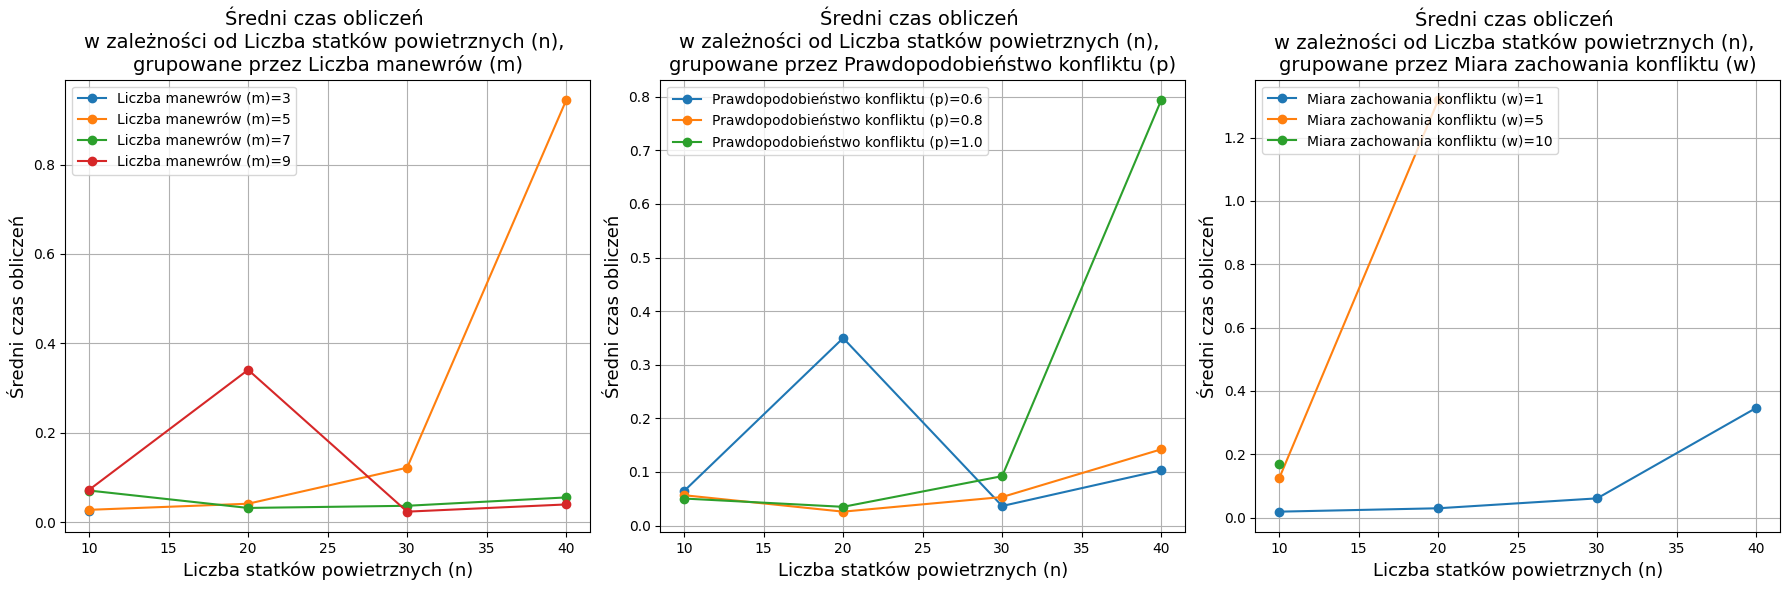

In [19]:
metrics_sets = [
    ['n', 'm'],  # Dla pary n-m
    ['n', 'p'],  # Dla pary n-p
    ['n', 'w'],  # Dla pary n-w
]
all_agg_data = {tuple(pair): double_aggregate_data(data, pair) for pair in metrics_sets}

plot_aggregated_data(all_agg_data, 'n', ['m', 'p', 'w'])

Na przedstawionych wykresach obserwujemy, że czas obliczeń jest względnie niski i stabilny dla m = 3, 5, 7 niezależnie od liczby statków, jednak znacząco wzrasta przy m = 9 dla n = 40, sugerując, że większa liczba manewrów może drastycznie zwiększać złożoność obliczeniową w przypadku dużej liczby statków.
Dla prawdopodobieństwa konfliktu p = 1.0 czas obliczeń gwałtownie rośnie przy n = 40, co wskazuje na to, że wysokie prawdopodobieństwo konfliktu znacząco wpływa na czas obliczeń przy większej liczbie statków.
W przypadku miary zachowania konfliktu w, obserwujemy znaczący wzrost czasu obliczeń dla w = 10 przy n = 40, co sugeruje, że wyższe wartości tego parametru mogą zwiększać złożoność problemu przy dużych wartościach n.

Na wykresach widoczny jest wzrost czasu obliczeń przy zwiększaniu liczby statków dla niektórych parametrów, ale nie można jednoznacznie stwierdzić, czy wzrost ten jest wykładniczy.
Dla niektórych zestawów parametrów, jak m = 9, p = 1.0, i w = 10 przy n = 40, obserwujemy znaczny wzrost, ale wzorzec nie jest konsekwentnie wykładniczy w całym zakresie danych, co wymagałoby dalszych analiz z użyciem większej ilości danych lub różnorodniejszych scenariuszy.

<h6>Średni czas obliczeń w zależności od liczby manewrów <b>m</b> dla różnych wartości parametrów <b>n</b>, <b>p</b> i <b>w</b>:</h6>

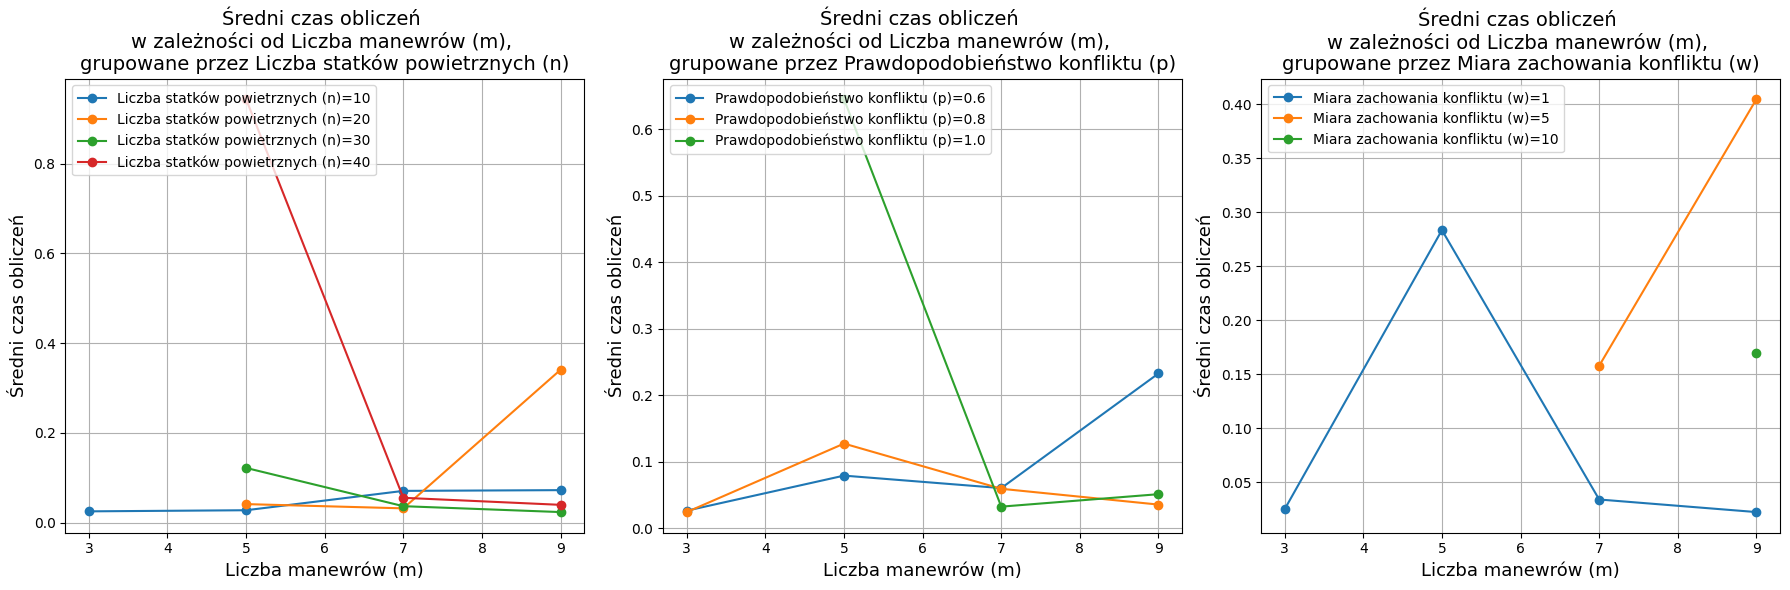

In [20]:
metrics_set = [
    ['m', 'n'],  # Dla pary m-n
    ['m', 'p'],  # Dla pary m-p
    ['m', 'w']  # Dla pary m-w
]
all_agg_data = {tuple(pair): double_aggregate_data(data, pair) for pair in metrics_set}
plot_aggregated_data(all_agg_data, 'm', ['n', 'p', 'w'])

Na przedstawionych wykresach obserwujemy, że czas obliczeń dla m=3, zawsze jest zerowy, co oznacza, że dla tej wartości parametru algorytm nigdy nie znajduje optymalnego rozwiązania (średni czas był obliczny tylko dla instancji, w których znaleziono co najmniej jedno rozwiązanie optymalne)- tak małej ilości manewrów, uniknięcie konfliktów może być niemożliwe.
Interesującym zjawiskiem jest spadek czasu obliczeń dla <b>m=9</b> przy <b>p=1.0</b>, co jest przeciwnym trendem do obserwowanego przy niższych wartościach <b>p</b>. Spadek ten może wynikać z tego, że przy wyższym prawdopodobieństwie konfliktu, większa liczba manewrów umożliwia szybsze znajdowanie rozwiązań dopuszczalnych poprzez eliminację niewykonalnych ścieżek.
Wykres pokazuje znaczny wzrost czasu obliczeń dla <b>m=9</b> przy najwyższej wartości <b>w=10</b>. To może sugerować, że wyższe wartości <b>w</b>, które ograniczają elastyczność w unikaniu konfliktów, sprawiają, że większa liczba manewrów może skutkować dłuższym czasem potrzebnym na znalezienie rozwiązania.

Hipoteza zakładała, że zwiększenie liczby możliwych manewrów <b>m</b> ułatwi znalezienie rozwiązania dopuszczalnego. Obserwacje sugerują, że choć zwiększenie liczby manewrów może w niektórych przypadkach ułatwić znalezienie rozwiązania dopuszczalnego, nie jest to regułą i skuteczność tego podejścia zależy od specyfiki problemu, w tym od prawdopodobieństwa konfliktu oraz ograniczeń nałożonych przez parametr <b>w</b>.







<h6>Średni czas obliczeń w zależności od prawdopodobieństwa konfliktu <b>p</b> dla różnych wartości parametrów <b>n</b>, <b>m</b> i <b>w</b>:</h6>

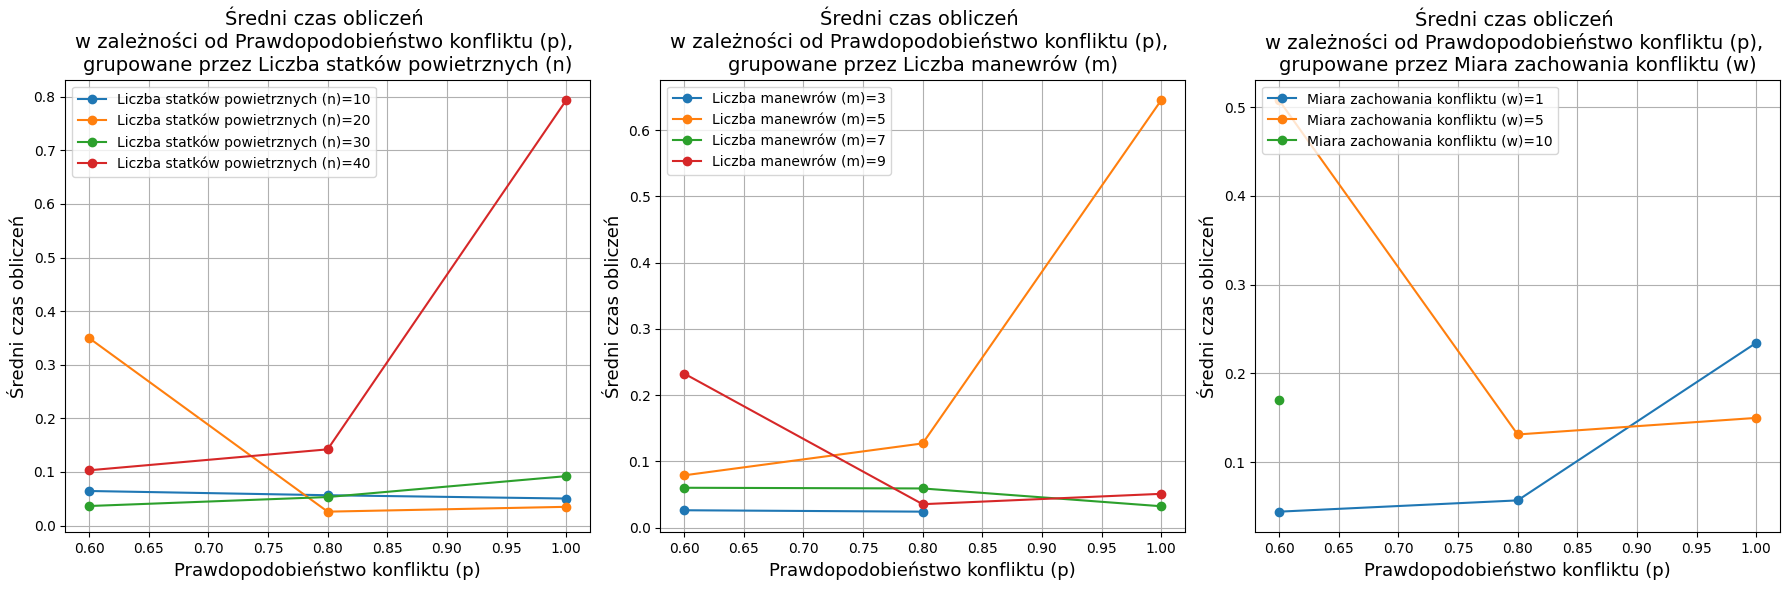

In [21]:
metrics_set = [
    ['p', 'n'],  # Dla pary p-n
    ['p', 'm'],  # Dla pary p-m
    ['p', 'w']  # Dla pary p-w
]
all_agg_data = {tuple(pair): double_aggregate_data(data, pair) for pair in metrics_set}
plot_aggregated_data(all_agg_data, 'p', ['n', 'm', 'w'])

Na przedstawionych wykresach można zaobserować, że czasy obliczeń są stosunkowo krótkie dla instancji, w których prawdopodobieństwo konflitku jest stosunkowo "średnie". Na wszystkich wykresach możemy zaobserwować bardzo zbliżone wartości czasu obliczeń dla wszystkich instancji przy prawdopodobieństwie konfliktu p=0.8.

Natomiast zarówno dla wysokiego jak i niskiego prawdopodobieństwa konfliktu nie możemy jednocznacznie stwierdzić, czy czas obliczeń rośnie wraz z rosnącym prawdopodobieństwem konfliktu. Dla n=40, m=9, w=10 obserwujemy, że czas obliczeń jest najwyższy dla p=1.0, co może sugeorować, że w tym przypadku wysokie prawdopodobieństwo konfliktu znacząco wpływa na złożoność problemu. Jednakże dla miary zachowania konfliktu w=5, czas obliczeń jest najwyższy dla p=0.6, co sugeruje, że w tym przypadku inne czynniki mogą mieć większy wpływ na złożoność problemu.


<h6>Średni czas obliczeń w zależności od miary zachowania konfliktu <b>w</b> dla różnych wartości parametrów <b>n</b>, <b>m</b> i <b>p</b>:</h6>

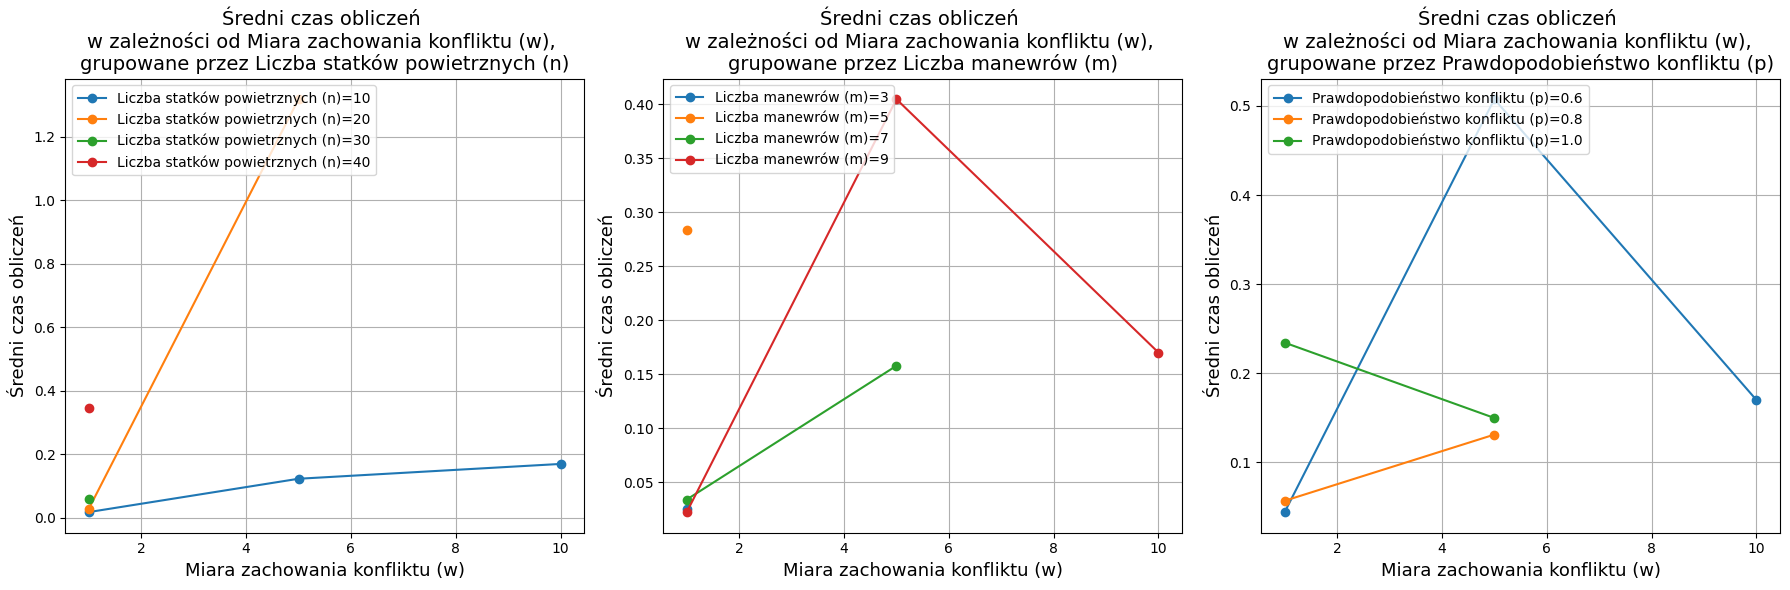

In [22]:
metrics_set = [
    ['w', 'n'],  # Dla pary w-n
    ['w', 'm'],  # Dla pary w-m
    ['w', 'p']  # Dla pary w-p
]
all_agg_data = {tuple(pair): double_aggregate_data(data, pair) for pair in metrics_set}
plot_aggregated_data(all_agg_data, 'w', ['n', 'm', 'p'])

Na podstawie wykresów średnich czasów obliczeń w zależności od miary zachowania konfliktu <b>w</b> nie możemy jednoznacznie stwierdzić, czy zwiększenie wartości parametru <b>w</b> wpływa w jakikolwiek sposób na złożoność obliczeń. Dla wszystkich wartości tego parametru na wszystkich wykresach obserwujemy kompletnie różne wartości czasu obliczeń, nie reprezentujące żadnego jednoznacznego trendu.

Jedyna zaleznością, którą możemy zaobserwować jest fakt, że dla w=1, czas obliczeń w większości przypadków wynosi 0 - brak znalezionego rozwiązańa optymalnego dla wszystkich instancji, co świadczy o tym, że wartość parametru <b>w</b> ma kluczowe znaczenie dla skuteczności algorytmu w unikaniu konfliktów i powinna być odpowiednio zbalansowana z innymi parametrami, takimi jak liczba manewrów <b>m</b> czy prawdopodobieństwo konfliktu <b>p</b>.

<h6> Dodatkowo warto pokazać trend wartości funkcji celu w zależnosci od średniego czasu obliczeń.</h6>

In [23]:
def plot_objective_value_vs_time(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['AVG Time'], df['AVG Objective Value'], color='b', label='Wartość funkcji celu vs średni czas obliczeń')

    # Usuwanie outlierów
    q_low = df['AVG Objective Value'].quantile(0.01)
    q_high = df['AVG Objective Value'].quantile(0.99)
    df_filtered = df[(df['AVG Objective Value'] > q_low) & (df['AVG Objective Value'] < q_high)]

    # Dopasowanie modelu liniowego po usunięciu outlierów
    z = np.polyfit(df_filtered['AVG Time'], df_filtered['AVG Objective Value'], 2)
    p = np.poly1d(z)
    trendline_x = np.linspace(df_filtered['AVG Time'].min(), df_filtered['AVG Time'].max(), 100)
    trendline_y = p(trendline_x)
    plt.plot(trendline_x, trendline_y, "r--", label='Linia trendu')

    plt.title('Zależność wartości funkcji celu od średniego czasu obliczeń')
    plt.xlabel('Średni czas obliczeń')
    plt.ylabel('Wartość funkcji celu')
    plt.grid(True)
    plt.legend()
    plt.show()

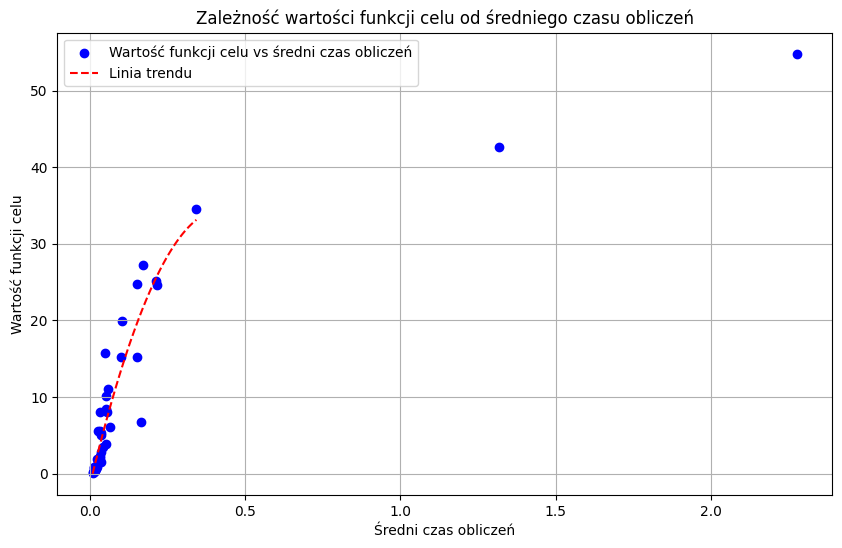

In [24]:
data = pd.read_csv('./results/results_aggregated.csv')
plot_objective_value_vs_time(data)

<h3>8. Podsumowanie</h3>

Celem przeprowadzonego eksperymentu było zbadanie efektywności algorytmu ILOG CPLEX rozwiązującego optymalizacyjny problem dekonfliktacji statków powietrznych (MIP – Mixed Integer Programming Problem), przy zmieniających się rozmiarach i parametrach instancji. Eksperyment skupiał się na analizie wpływu różnych parametrów na czas obliczeń oraz skuteczność algorytmu w znajdowaniu rozwiązań dopuszczalnych.

<b>Wzrost liczby statków powietrznych:</b>
Zauważono, że zwiększenie liczby statków prowadzi do wzrostu czasu obliczeń. Ten trend był szczególnie widoczny przy większych wartościach parametrów, co sugeruje, że złożoność problemu rośnie wraz z liczbą uczestniczących jednostek.

<b>Wzrost liczby możliwych manewrów:</b>
W przypadku zwiększenia liczby manewrów, algorytm wykazywał lepszą zdolność do znajdowania rozwiązań w krótszym czasie przy wyższym prawdopodobieństwie konfliktu, co może wynikać z większej przestrzeni opcji unikania konfliktów. Jednak w przypadkach, gdy parametr w był wysoki, obserwowano zwiększenie czasu obliczeń, co wskazuje na to, że nadmierne ograniczenia mogą utrudniać efektywną optymalizację.

<b>Wpływ prawdopodobieństwa konfliktu:</b>
"Najlepszą" - najstabilniejszą, dla których wartości czasu obliczeń były najbardziej zbliżone - wartością parametru prawdopodobieństwa konfliktu był p=0.8. Może to sugerować, że algorytm nie radzi sobie najlepiej z ekstremalnymi wartościami prawdopodobieństwa konfliktu, co prowadziło do zwiększenia czasu obliczeń.

<b>Miara zachowania konfliktu:</b>
 Na podstawie otrzymanych czasów obliczeń można było jednoznacznie określić wpływu miary zachowania konfliktu do czasu obliczeń. Sugeruje to, że algorytm jest wrażliwy na wartości tego parametru i jego odpowiednie skalibrowanie jest kluczowe dla efektywnego rozwiązania problemu dla danej instancji.

<h5>Ogólne spostrzeżenia:</h5>

Algorytm ILOG CPLEX radził sobie różnie w zależności od ustawień parametrów, co sugeruje, że odpowiednia kalibracja tych parametrów jest kluczowa dla optymalizacji czasu obliczeń i efektywności rozwiązań. Eksperyment pokazał, że zrozumienie wpływu poszczególnych parametrów na działanie algorytmu jest niezbędne do jego efektywnego wykorzystania w praktyce.